# Transformer와 비교해 변경이 필요한 부분
- positional encoding 클래스 제거, positional embedding 추가
- padding mask 제거, look-ahaed mask만 남김
- 인코더 제거, 디코더만 남김
- 디코더에서 Cross-Attention 제거, Self-Attention만 수행
- forward 함수에서 enc_outputs, padding_mask 제거
- 라벨을 포함해서 Q, A까지 하나의 시퀀스로 결합하여 말뭉치 생성
- SentencePiece 학습 옵션에 특수 토큰 추가(\<sep>, \<lab0>, \<lab1>, \<lab2>)
- 마스크 학습 : 프리픽스(\<labX> Q \<sep>)는 0, A부터 1인 loss_mask 추가
- SPM 특수 토큰 전제 : \<sep>, \<lab0>, \<lab1>, \<lab2>를 user_defined_symbols로 SPM 학습에 등록
- 모델 포워드 : model(dec_inputs) 한 가지만 받도록 변경 (인코더 없음).
- 데이터 배치 형식: dec_input, target, loss_mask 를 받도록 변경 (라벨+질문 프리픽스는 손실/정확도에서 제외).
- 손실 계산: CrossEntropy(reduction='none') → loss_mask로 가중합.
- 정확도: loss_mask 기준으로만 계산(패딩/프리픽스 제외).
- 추론: 인코더 입력 제거, BOS로 시작한 디코더 시퀀스만 점증(greedy) 생성.

# 공통

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AIFFEL


In [2]:
! mkdir -p ./work/gpt_chatbot/data/
! wget https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
! mv ChatbotData.csv ./work/gpt_chatbot/data/
! pip install sentencepiece

--2025-11-05 08:00:10--  https://github.com/songys/Chatbot_data/raw/master/ChatbotData.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv [following]
--2025-11-05 08:00:10--  https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 889842 (869K) [text/plain]
Saving to: ‘ChatbotData.csv’

ChatbotData.csv     100%[===================>] 868.99K  --.-KB/s    in 0.03s   

2025-11-05 08:00:10 (28.2 MB/s) - ‘ChatbotData.csv’ saved [889842/889842]



In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
import sentencepiece as spm

import math
import os
import re
import urllib.request
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import torch
print(torch.__version__)

2.8.0+cu126


# GPT 입력 이해하기

In [5]:
'''class PositionalEncoding(nn.Module):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        self.position = position

        self.pos_encoding = self._build_pos_encoding(position, d_model)

    def _get_angles(self, position, i, d_model):
        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position

    def _build_pos_encoding(self, position, d_model):
        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)
        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)

        angle_rads = self._get_angles(pos, i, d_model)
        sines = torch.sin(angle_rads[:, 0::2])
        cosines = torch.cos(angle_rads[:, 1::2])

        pos_encoding = torch.zeros(position, d_model)
        pos_encoding[:, 0::2] = sines
        pos_encoding[:, 1::2] = cosines

        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]
        return pos_encoding

    def forward(self, x):
        return x + self.pos_encoding[:, :x.size(1), :].to(x.device)'''

'class PositionalEncoding(nn.Module):\n    def __init__(self, position, d_model):\n        super(PositionalEncoding, self).__init__()\n        self.d_model = d_model\n        self.position = position\n\n        self.pos_encoding = self._build_pos_encoding(position, d_model)\n\n    def _get_angles(self, position, i, d_model):\n        return 1.0 / (10000.0 ** ((2.0 * (i // 2)) / d_model)) * position\n\n    def _build_pos_encoding(self, position, d_model):\n        pos = torch.arange(position, dtype=torch.float32).unsqueeze(1)\n        i = torch.arange(d_model, dtype=torch.float32).unsqueeze(0)\n\n        angle_rads = self._get_angles(pos, i, d_model)\n        sines = torch.sin(angle_rads[:, 0::2])\n        cosines = torch.cos(angle_rads[:, 1::2])\n\n        pos_encoding = torch.zeros(position, d_model)\n        pos_encoding[:, 0::2] = sines\n        pos_encoding[:, 1::2] = cosines\n\n        pos_encoding = pos_encoding.unsqueeze(0)  # shape: [1, position, d_model]\n        return pos_en

In [6]:
# Positional Encoding이 아닌 Postional Embedding으로 변경
class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_seq_len, d_model, dropout=0.1):
        super().__init__()
        self.pos_emb = nn.Embedding(max_seq_len, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        x: (B, T, D)
        """
        B, T, _ = x.size()
        device = x.device
        # 0~T-1까지의 위치 인덱스
        positions = torch.arange(T, device=device).unsqueeze(0).expand(B, T)
        x = x + self.pos_emb(positions)
        return self.dropout(x)

# 어텐션 구현

## Scaled dot product attention

In [7]:
def scaled_dot_product_attention(query, key, value, mask=None):

    # 1) Q와 K의 내적을 통해 score(유사도) 계산
    # key.transpose(-1, -2): (batch_size, heads, depth, seq_len)
    # matmul 결과 shape: (batch_size, heads, seq_len, seq_len)
    matmul_qk = torch.matmul(query, key.transpose(-1, -2))

    # 2) depth에 따라 정규화
    depth = key.size(-1)  # depth = d_model / heads
    logits = matmul_qk / math.sqrt(depth)

    # 3) 마스크가 주어졌다면 -1e9(아주 작은 값)를 더해 소프트맥스에서 제외시키도록 함
    if mask is not None:
        # 텐서플로우: logits += (mask * -1e9)
        # 파이토치 동일 적용
        logits = logits + (mask * -1e9)

    # 4) 소프트맥스 계산해 attention weights 생성
    attention_weights = F.softmax(logits, dim=-1)

    # 5) attention weights와 value의 내적
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

## Multi Head Attention

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        # d_model은 num_heads로 나누어떨어져야 함
        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        # 파이토치에서 Dense는 nn.Linear로 대응
        self.query_dense = nn.Linear(d_model, d_model)
        self.key_dense = nn.Linear(d_model, d_model)
        self.value_dense = nn.Linear(d_model, d_model)

        self.out_dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        x: (batch_size, seq_len, d_model)
        => (batch_size, num_heads, seq_len, depth) 형태로 변환
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        x = x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)
        return x

    def forward(self, query, key, value, mask=None):
        """
        query, key, value: (batch_size, seq_len, d_model)
        mask: (batch_size, 1, seq_len, seq_len) 등으로 broadcast 가능하도록 구성
        """
        batch_size = query.size(0)

        # Q, K, V에 각각 Linear 적용
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Head 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)

        # (batch_size, num_heads, seq_len, depth) -> (batch_size, seq_len, num_heads, depth)
        scaled_attention = scaled_attention.permute(0, 2, 1, 3).contiguous()

        # 다시 (batch_size, seq_len, d_model)로 합치기
        concat_attention = scaled_attention.view(batch_size, -1, self.d_model)

        # 최종 Dense
        output = self.out_dense(concat_attention)
        return output


# Masking

## Padding Masking 제거

In [9]:
'''def create_padding_mask(x):
    # x == 0 위치를 찾아 float형 1로 변환
    mask = (x == 0).float()
    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)
    mask = mask.unsqueeze(1).unsqueeze(2)
    return mask'''

'def create_padding_mask(x):\n    # x == 0 위치를 찾아 float형 1로 변환\n    mask = (x == 0).float()\n    # (batch_size, seq_len) -> (batch_size, 1, 1, seq_len)\n    mask = mask.unsqueeze(1).unsqueeze(2)\n    return mask'

In [10]:
'''x = torch.tensor([[1, 2, 0, 3, 0],
                  [0, 0, 0, 4, 5]])
mask = create_padding_mask(x)
print("입력 텐서 크기 :", x.shape)    # (2, 5)
print("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)
print(mask)'''

'x = torch.tensor([[1, 2, 0, 3, 0],\n                  [0, 0, 0, 4, 5]])\nmask = create_padding_mask(x)\nprint("입력 텐서 크기 :", x.shape)    # (2, 5)\nprint("생성된 마스크 크기 :", mask.shape)  # (2, 1, 1, 5)\nprint(mask)'

## Look-ahead masking

In [11]:
def create_look_ahead_mask(x):
    seq_len = x.size(1)

    # (seq_len, seq_len) 크기의 하삼각 행렬(tril) 생성 후 1에서 빼서
    # 상삼각이 1, 하삼각(자기 자신 포함)이 0이 되도록 설정
    # => 미래 토큰(자신 인덱스보다 큰 위치) 마스킹
    look_ahead_mask = 1 - torch.tril(torch.ones((seq_len, seq_len)))

    # 패딩 마스크 제거
    '''
    # 패딩 마스크 생성 (shape: (batch_size, 1, 1, seq_len))
    padding_mask = create_padding_mask(x)
    '''

    # look_ahead_mask: (seq_len, seq_len) -> (1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(0)
    # -> (1, seq_len, seq_len) -> (1, 1, seq_len, seq_len)
    look_ahead_mask = look_ahead_mask.unsqueeze(1)
    look_ahead_mask = look_ahead_mask.to(x.device)

    # look-ahead 마스크와 패딩 마스크를 합성 (둘 중 하나라도 1이면 마스킹)
    # 최종 shape은 브로드캐스팅으로 (batch_size, 1, seq_len, seq_len)
    '''
    combined_mask = torch.max(look_ahead_mask, padding_mask)
    return combined_mask
    '''
    return look_ahead_mask

In [12]:
x = torch.tensor([[1, 2, 3, 4, 5]])
mask_1 = create_look_ahead_mask(x)
print("첫 번째 시퀀스:\n", mask_1, mask_1.shape)

첫 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


In [13]:
x2 = torch.tensor([[0, 5, 1, 5, 5]])
mask_2 = create_look_ahead_mask(x2)
print("두 번째 시퀀스:\n", mask_2, mask_2.shape)

두 번째 시퀀스:
 tensor([[[[0., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1.],
          [0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0.]]]]) torch.Size([1, 1, 5, 5])


# 인코더 : 주석 처리 하여 제거

In [14]:
'''class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 피드포워드 부분 (Dense -> ReLU -> Dense)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, d_model)
        )
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)

    def forward(self, x, mask=None):
        # (1) 멀티 헤드 어텐션 (셀프 어텐션)
        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm

        # (2) 피드포워드 신경망
        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.norm2(out1 + ffn_output)   # 잔차 연결 + LayerNorm

        return out2'''

'class EncoderLayer(nn.Module):\n    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):\n        super(EncoderLayer, self).__init__()\n        self.mha = MultiHeadAttention(d_model, num_heads)  # 이전에 구현한 MHA\n        self.dropout1 = nn.Dropout(dropout)\n        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)\n\n        # 피드포워드 부분 (Dense -> ReLU -> Dense)\n        self.ffn = nn.Sequential(\n            nn.Linear(d_model, ff_dim),\n            nn.ReLU(),\n            nn.Linear(ff_dim, d_model)\n        )\n        self.dropout2 = nn.Dropout(dropout)\n        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)\n\n    def forward(self, x, mask=None):\n        # (1) 멀티 헤드 어텐션 (셀프 어텐션)\n        attn_output = self.mha(x, x, x, mask)  # (batch_size, seq_len, d_model)\n        attn_output = self.dropout1(attn_output)\n        out1 = self.norm1(x + attn_output)     # 잔차 연결 + LayerNorm\n\n        # (2) 피드포워드 신경망\n        ffn_output = self.ffn(out1)            # (batch_size, seq_len, d_model)\n    

In [15]:
'''class Encoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 인코딩
        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)

        self.dropout = nn.Dropout(dropout)

        # (3) EncoderLayer 쌓기
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    def forward(self, x, mask=None):
        # (1) 임베딩 & sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 적용 + 드롭아웃
        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓아올린 EncoderLayer 통과
        for layer in self.enc_layers:
            x = layer(x, mask)

        return x'''

'class Encoder(nn.Module):\n    def __init__(self,\n                 vocab_size,\n                 num_layers,\n                 ff_dim,\n                 d_model,\n                 num_heads,\n                 dropout=0.1):\n        super(Encoder, self).__init__()\n        self.d_model = d_model\n\n        # (1) 임베딩 레이어\n        self.embedding = nn.Embedding(vocab_size, d_model)\n\n        # (2) 포지셔널 인코딩\n        self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)\n\n        self.dropout = nn.Dropout(dropout)\n\n        # (3) EncoderLayer 쌓기\n        self.enc_layers = nn.ModuleList([\n            EncoderLayer(d_model, num_heads, ff_dim, dropout)\n            for _ in range(num_layers)\n        ])\n\n    def forward(self, x, mask=None):\n        # (1) 임베딩 & sqrt(d_model)로 스케일링\n        x = self.embedding(x) * math.sqrt(self.d_model)\n\n        # (2) 포지셔널 인코딩 적용 + 드롭아웃\n        x = self.pos_encoding(x)  # shape: (batch_size, seq_len, d_model)\n        x = self.d

# 디코더

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super(DecoderLayer, self).__init__()

        # 첫 번째 서브 레이어 (디코더 내부 셀프 어텐션)
        self.self_mha = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model, eps=1e-6)

        # 크로스 어텐션 제거
        '''# 두 번째 서브 레이어 (인코더-디코더 어텐션)
        self.encdec_mha = MultiHeadAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model, eps=1e-6)
        '''

        # 세 번째 서브 레이어 (피드포워드 네트워크)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_dim),  # Dense(units=ff_dim)
            nn.ReLU(),                   # activation='relu'
            nn.Linear(ff_dim, d_model)   # Dense(units=d_model)
        )
        self.norm3 = nn.LayerNorm(d_model, eps=1e-6)

        # 드롭아웃
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        '''self.dropout3 = nn.Dropout(dropout)'''

    # enc_outputs, padding_mask 제거
    def forward(self, x, look_ahead_mask=None):
        # 1) 셀프 어텐션 (디코더 내부)
        self_attn_out = self.self_mha(x, x, x, mask=look_ahead_mask)
        self_attn_out = self.dropout1(self_attn_out)
        out1 = self.norm1(x + self_attn_out)  # 잔차 연결 + LayerNorm

        # 크로스 어텐션 제거
        '''# 2) 인코더-디코더 어텐션
        encdec_attn_out = self.encdec_mha(out1, enc_outputs, enc_outputs, mask=padding_mask)
        encdec_attn_out = self.dropout2(encdec_attn_out)
        out2 = self.norm2(out1 + encdec_attn_out)  # 잔차 연결 + LayerNorm'''

        # 3) 피드포워드 (Dense -> ReLU -> Dense)
        ffn_out = self.ffn(out1)
        ffn_out = self.dropout2(ffn_out)
        out3 = self.norm3(out1 + ffn_out)  # 잔차 연결 + LayerNorm

        return out3

In [17]:
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,
                 ff_dim,
                 d_model,
                 num_heads,
                 dropout=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model

        # (1) 임베딩 레이어
        self.embedding = nn.Embedding(vocab_size, d_model)

        # (2) 포지셔널 임베딩
        # 실제 학습 시에는 최대 시퀀스 길이에 맞추어 쓰기도 함
        '''self.pos_encoding = PositionalEncoding(position=vocab_size, d_model=d_model)'''
        self.pos_encoding = LearnedPositionalEmbedding(max_seq_len=1024, d_model=d_model, dropout=dropout)


        self.dropout = nn.Dropout(dropout)

        # (3) DecoderLayer 쌓기
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

    # enc_outputs, padding_mask 제거
    def forward(self, x, look_ahead_mask=None):
        # (1) 임베딩 + sqrt(d_model)로 스케일링
        x = self.embedding(x) * math.sqrt(self.d_model)

        # (2) 포지셔널 인코딩 + 드롭아웃
        x = self.pos_encoding(x)    # (batch_size, tgt_seq_len, d_model)
        x = self.dropout(x)

        # (3) num_layers만큼 쌓인 DecoderLayer 통과
        for layer in self.dec_layers:
            x = layer(x, look_ahead_mask)

        return x

# 챗봇 데이터 확인하기

[Chatbot_data 출처](https://github.com/songys/Chatbot_data)

In [18]:
# 챗봇 데이터 폴더 경로
path_to_dataset = '/content/drive/MyDrive/AIFFEL/work/gpt_chatbot/data'

# 개별 파일 경로 설정
path_to_ko_chatbot = os.path.join(path_to_dataset, 'ChatbotData.csv')

print("path_to_dataset:", path_to_dataset)
print("path_to_ko_chatbot:", path_to_ko_chatbot)

path_to_dataset: /content/drive/MyDrive/AIFFEL/work/gpt_chatbot/data
path_to_ko_chatbot: /content/drive/MyDrive/AIFFEL/work/gpt_chatbot/data/ChatbotData.csv


In [19]:
raw_data = pd.read_csv(path_to_ko_chatbot)
raw_data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [20]:
# 챗봇 트레이닝용 문답 페어 11,876개
# 일상다반사 0, 이별(부정) 1, 사랑(긍정) 2로 레이블링
raw_data.groupby('label').count()

,Q,A
label,,
0,5290,5290
1,3570,3570
2,2963,2963


In [21]:
# 0 : 일상 공감
label_0 = raw_data[raw_data['label'] == 0]
label_0.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [22]:
# 1 : 이별(부정)
label_1 = raw_data[raw_data['label'] == 1]
label_1.head()

,Q,A,label
5290,1000일 만난 여자친구와 이별,더 오래 만날 사람 만날 거예요.,1
5291,10년 연애. 헤어졌습니다.,더 공허함이 크시겠네요.,1
5292,10년 연애사 되돌아보니 다 부질없네,더 좋은 사람 만나실 거예요.,1
5293,10년 연예의끝,더 마음이 허하겠어요.,1
5294,10년만나다 헤어지네,충분히 슬퍼하고 충분히 아파하다가 이겨내세요.,1


In [23]:
# 2 : 사랑(긍정)
label_2 = raw_data[raw_data['label'] == 2]
label_2.head()

,Q,A,label
8860,짝사랑만큼 고통스러운 건 없겠지.,짝사랑 만큼 감정소모가 큰 건 없을 거예요.,2
8861,1년 넘게 만났는데 지금도 불타올라,정열적인 사랑을 하고 있나봐요.,2
8862,1년 동거 중인데 계속 좋아,서로 깊게 알게되면서 더 좋아졌나봅니다.,2
8863,1년 동거하고 결혼했어,축하합니다!,2
8864,1년 만났는데도 그 사람에 대해 잘 모르겠어,더 만나보세요.,2


# 사용할 샘플 최대 개수 정의, 전처리 함수, 챗봇 데이터 가공 함수 정의

In [24]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

50000


In [25]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 1. 양쪽 공백 제거
    sentence = sentence.strip()

    # 2. 특수문자 및 이모지 제거 (한글, 영어, 숫자, 기본 구두점만 허용)
    sentence = re.sub(r"[^가-힣0-9a-zA-Z.,!?~\s]", " ", sentence)

    # 3. 연속된 공백 하나로 축소
    sentence = re.sub(r"\s+", " ", sentence)

    # 4. 문장 부호 앞뒤로 공백 추가 (토큰 구분을 위함)
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
    sentence = re.sub(r'\s{2,}', ' ', sentence)

    return sentence.strip()

In [26]:
sample_sentence = "안녕하세요? Hello! I'm a student😊, nice to meet you! 1년 만났는데도 그 사람에 대해 잘 모르겠어."

preprocessed_sentence = preprocess_sentence(sample_sentence)
print(preprocessed_sentence)

안녕하세요 ? Hello ! I m a student , nice to meet you ! 1년 만났는데도 그 사람에 대해 잘 모르겠어 .


In [27]:
def read_ko_chatbot_data(
    path_to_csv,
    max_samples=50000,
    drop_duplicates=True,
    shuffle=True,
    seed=42,
    min_len=1,
    use_label=False
):
    """
    CSV 파일에서 Q/A 쌍을 읽고, 전처리한 뒤 (Q, A) 튜플 리스트를 반환합니다.
    CSV에는 반드시 'Q', 'A' 컬럼이 포함되어야 하며,
    'label' 컬럼이 있을 경우 use_label=True로 설정하면 함께 반환합니다.
    """

    # 1️⃣ CSV 로드 (인코딩 자동 시도)
    encodings = ["utf-8-sig", "utf-8", "cp949"]
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(path_to_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            df = None
    if df is None:
        raise last_err

    # 2️⃣ 컬럼 확인
    if not {"Q", "A"}.issubset(df.columns):
        raise ValueError("CSV에는 반드시 'Q', 'A' 컬럼이 포함되어야 합니다.")

    # 3️⃣ 기본 정리
    df["Q"] = df["Q"].astype(str).str.strip()
    df["A"] = df["A"].astype(str).str.strip()

    # 4️⃣ 결측치 제거
    df = df.replace({"Q": {"": np.nan}, "A": {"": np.nan}}).dropna(subset=["Q", "A"])

    # 5️⃣ 중복 제거
    if drop_duplicates:
        df = df.drop_duplicates(subset=["Q", "A"])

    # 6️⃣ 전처리 적용
    df["Q"] = df["Q"].apply(preprocess_sentence)
    df["A"] = df["A"].apply(preprocess_sentence)

    # 7️⃣ 너무 짧은 문장 제거
    df = df[(df["Q"].str.len() >= min_len) & (df["A"].str.len() >= min_len)]

    # 8️⃣ 셔플
    if shuffle:
        df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)

    # 9️⃣ 최대 샘플 제한
    if max_samples is not None:
        df = df.iloc[:max_samples]

    # 🔟 label 컬럼 처리
    if use_label and "label" in df.columns:
        return list(df[["Q", "A", "label"]].itertuples(index=False, name=None))
    else:
        # label을 사용하지 않거나 컬럼이 없으면 제거
        return list(df[["Q", "A"]].itertuples(index=False, name=None))

In [28]:
pairs_labels = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES, use_label=True)

print('전체 샘플 수 :', len(pairs_labels))
print("첫 번째 페어 : ", pairs_labels[0])

전체 샘플 수 : 11750
첫 번째 페어 :  ('사랑이란 뭘까 ?', '사랑에는 답이 없어요 .', 1)


# 병렬 데이터 전처리하기

## Tokenizer 학습

pair로 묶은 데이터를 말뭉치로 전환

In [29]:
# 라벨, sep 토큰 정의
LABEL_TOKENS = {0: "<lab0>", 1: "<lab1>", 2: "<lab2>"}
SEP_TOKEN = "<sep>"

In [30]:
pairs_labels = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES, use_label=True)

corpus_file = "/content/drive/MyDrive/AIFFEL/work/gpt_chatbot/data/clean_corpus.txt"
with open(corpus_file, 'w', encoding='utf-8') as f:
    for q, a, label in pairs_labels:
        lab = LABEL_TOKENS[int(label)]
        # 형식: <labX> Q <sep> A
        f.write(f"{lab} {q} {SEP_TOKEN} {a}\n")

In [31]:
spm.SentencePieceTrainer.Train(
    input=corpus_file,
    model_prefix="./work/gpt_chatbot/spm_ko_chatbot",
    vocab_size=8000,
    character_coverage=1.0,
    model_type="bpe",
    max_sentence_length=999999,
    bos_id=1,  # <s> (Beginning of Sentence) 설정
    eos_id=2,  # </s> (End of Sentence) 설정
    pad_id=0,  # Padding ID 설정
    unk_id=3,   # Unknown Token ID 설정
    user_defined_symbols=[SEP_TOKEN, "<lab0>", "<lab1>", "<lab2>"]
)


In [32]:
sp = spm.SentencePieceProcessor()
sp.Load("./work/gpt_chatbot/spm_ko_chatbot.model")

True

In [33]:
# 예제 문장
sentence = "내가 싫어졌대! 나 이제 어떻게 살아야 해?"

sentence = preprocess_sentence(sentence)
print("전처리 후의 문장:", sentence)

# 1. 토크나이징 (subword 단위로 분할)
tokens = sp.encode(sentence, out_type=str)
print("Tokenized:", tokens)

# 2. 인코딩 (서브워드를 정수 ID로 변환)
encoded = sp.encode(sentence, out_type=int)
print("Encoded:", encoded)

# 3. 디코딩 (정수 ID → 원본 문장 복원)
decoded = sp.decode(encoded)
print("Decoded:", decoded)


전처리 후의 문장: 내가 싫어졌대 ! 나 이제 어떻게 살아야 해 ?
Tokenized: ['▁내가', '▁싫어', '졌', '대', '▁!', '▁나', '▁이제', '▁어떻게', '▁살아야', '▁해', '▁?']
Encoded: [169, 405, 6954, 6851, 116, 19, 149, 186, 3412, 35, 15]
Decoded: 내가 싫어졌대 ! 나 이제 어떻게 살아야 해 ?


## Dataset 구현

In [34]:
'''
입력 결합 방식
(전) Q와 A를 따로 만들어 enc/dec로 분리
(후) "<labX> Q <sep> A" 한 줄 시퀀스로 결합 → 디코더-온리

마스크 학습
(전) 타깃 전체(A)에 손실
(후) 프리픽스(<labX> Q <sep>)는 0, A부터 1인 loss_mask 추가

반환 값
(전) (enc_input, dec_input, target)
(후) (dec_input, target, loss_mask)

SPM 특수 토큰 전제
<sep>, <lab0>, <lab1>, <lab2>를 **user_defined_symbols**로 SPM 학습에 등록했는지 확인(필수).
'''

class KoChatbotDataset(Dataset):
    def __init__(
        self,
        pairs_or_triples,   # [(Q,A)] 또는 [(Q,A,label)]
        sp,
        max_length=40,
        sep_token="<sep>",
        label_tokens={0: "<lab0>", 1: "<lab1>", 2: "<lab2>"},
        use_label=True
    ):
        super().__init__()
        self.sp = sp
        self.max_length = max_length
        self.sep_token = sep_token
        self.label_tokens = label_tokens
        self.use_label = use_label
        self.data = []

        # --- special ids ---
        pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0
        bos_id = sp.bos_id() if sp.bos_id() >= 0 else 1
        eos_id = sp.eos_id() if sp.eos_id() >= 0 else 2
        unk_id = sp.unk_id() if sp.unk_id() >= 0 else 3

        def safe_piece_to_id(tok):
            try:
                return sp.PieceToId(tok)
            except Exception:
                return unk_id
        sep_id = safe_piece_to_id(sep_token)
        lab_id_map = {k: safe_piece_to_id(v) for k, v in label_tokens.items()}

        for item in pairs_or_triples:
            # 1) 데이터 분해
            if self.use_label and len(item) == 3:
                q_text, a_text, label = item
                lab_id = lab_id_map.get(int(label), lab_id_map.get(0, unk_id))
            else:
                q_text, a_text = item[:2]
                lab_id = None

            # 2) 토크나이즈
            q_ids = self.sp.EncodeAsIds(q_text)
            a_ids = self.sp.EncodeAsIds(a_text)

            # 3) 프리픽스 (<labX> Q <sep>) + A → 단일 시퀀스
            prefix_ids = []
            if lab_id is not None:
                prefix_ids.append(lab_id)
            prefix_ids.extend(q_ids)
            prefix_ids.append(sep_id)

            seq = [bos_id] + prefix_ids + a_ids + [eos_id]   # 전체길이 L
            if len(seq) > max_length:
                continue

            # 4) 디코더 입력/타겟
            dec_input = seq[:-1]      # (L-1)
            target    = seq[1:]       # (L-1)

            # 5) 손실마스크: 답변(A)부터만 1, 그 전은 0
            prefix_len = len(prefix_ids)           # <labX> Q <sep>
            ans_start = 1 + prefix_len            # BOS 다음부터 prefix_len개 지나고 A 시작
            loss_mask = [0] * ans_start + [1] * (len(dec_input) - ans_start)

            # 6) 패딩
            need = (max_length - 1) - len(dec_input)   # (L-1)을 max_length-1로 맞춤
            if need < 0:
                continue
            dec_input += [pad_id] * need
            target    += [pad_id] * need
            loss_mask += [0]      * need    # pad는 손실 미반영

            self.data.append({
                "dec_input": dec_input,
                "target": target,
                "loss_mask": loss_mask,
            })

        self.pad_id = pad_id

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        s = self.data[idx]
        dec_input = torch.tensor(s["dec_input"], dtype=torch.long)
        target    = torch.tensor(s["target"], dtype=torch.long)
        loss_mask = torch.tensor(s["loss_mask"], dtype=torch.float32)
        return dec_input, target, loss_mask

# 모델 정의 및 학습

In [35]:
class GPT(nn.Module):
    def __init__(self,
                 vocab_size,
                 num_layers,      # 디코더 층 수
                 units,           # feed-forward 차원(ff_dim)
                 d_model,         # 임베딩/내부 차원
                 num_heads,       # 어텐션 헤드 수
                 dropout=0.1,
                 tie_weights=True,
                 combine_padding=False   # 논문 기준=False, 실전 안전=True
                 ):
        super().__init__()
        self.combine_padding = combine_padding

        # 디코더(앞서 '논문 기준'으로 정리한 버전 사용: enc_outputs/ padding_mask 없음)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            num_layers=num_layers,
            ff_dim=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout
        )

        # 최종 LM 헤드: (d_model) -> (vocab_size)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # (선택) 임베딩-출력 가중치 tying
        if tie_weights:
            self.lm_head.weight = self.decoder.embedding.weight

    def forward(self, dec_inputs):
        """
        dec_inputs: (B, T)  — 오른쪽 쉬프트된 디코더 입력(y_in)
        반환: logits (B, T, V)
        """
        # 1) causal(masked) 마스크
        look_ahead_mask = create_look_ahead_mask(dec_inputs)  # (B,1,T,T)

        # (옵션) 실전에서 패딩까지 같이 가리고 싶으면 결합 (논문 기준은 사용 X)
        if self.combine_padding:
            pad_mask = create_padding_mask(dec_inputs)        # (B,1,1,T)
            look_ahead_mask = torch.max(look_ahead_mask, pad_mask)

        # 2) 디코더 통과 (디코더-온리)
        dec_outputs = self.decoder(
            x=dec_inputs,
            look_ahead_mask=look_ahead_mask
        )  # (B, T, D)

        # 3) LM 헤드
        logits = self.lm_head(dec_outputs)  # (B, T, V)
        return logits

## 모델 생성

In [36]:
# === GPT-1 논문 기준 하이퍼파라미터 ===
NUM_LAYERS  = 12      # 디코더 블록 수
D_MODEL     = 768     # 임베딩/모델 차원
NUM_HEADS   = 12      # 멀티헤드 수 (768/12=64)
UNITS       = 3072    # FFN 차원 (≈ 4 * d_model)
DROPOUT     = 0.1
MAX_SEQ_LEN = 512     # 학습형 위치 임베딩 길이

# Vocab: 논문은 ~40k 권장. 이미 8k로 학습했다면 8000 유지 가능.
VOCAB_SIZE  = 40000   # 또는 8000 (현재 SPM 그대로 쓰려면)

# === GPT 모델 생성 ===
model = GPT(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    tie_weights=True,        # 논문 계열 관례
    combine_padding=False    # 논문 기준 causal-only. (실무에선 True 권장)
)

print(model)

GPT(
  (decoder): Decoder(
    (embedding): Embedding(40000, 768)
    (pos_encoding): LearnedPositionalEmbedding(
      (pos_emb): Embedding(1024, 768)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (dropout): Dropout(p=0.1, inplace=False)
    (dec_layers): ModuleList(
      (0-11): 12 x DecoderLayer(
        (self_mha): MultiHeadAttention(
          (query_dense): Linear(in_features=768, out_features=768, bias=True)
          (key_dense): Linear(in_features=768, out_features=768, bias=True)
          (value_dense): Linear(in_features=768, out_features=768, bias=True)
          (out_dense): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): ReLU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm3): LayerNorm((768,), eps=1e-06, elementwise_aff

## 손실 함수

In [37]:
loss_function = nn.CrossEntropyLoss(ignore_index=sp.pad_id())

## 커스텀 된 학습률

In [38]:
def get_lr_lambda(d_model, warmup_steps=4000):
    d_model = float(d_model)
    def lr_lambda(step):
        # step은 0부터 시작하므로 +1로 보정
        step = step + 1
        return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
    return lr_lambda

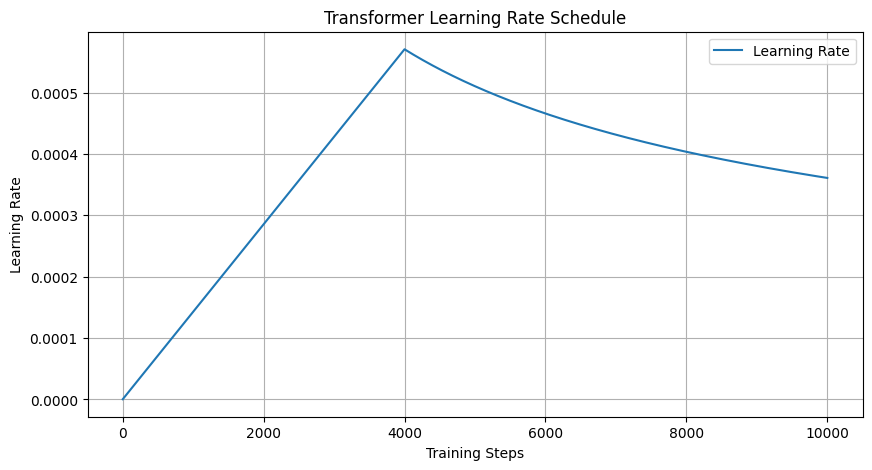

In [39]:
# 하이퍼파라미터 설정
d_model = 768
warmup_steps = 4000
total_steps = 10000  # 총 학습 스텝

# 학습률 스케줄 시각화
steps = np.arange(1, total_steps + 1)
learning_rates = [get_lr_lambda(d_model, warmup_steps)(step) for step in steps]

# 그래프 출력
plt.figure(figsize=(10, 5))
plt.plot(steps, learning_rates, label="Learning Rate")
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("Transformer Learning Rate Schedule")
plt.legend()
plt.grid(True)
plt.show()


## 모델 컴파일

In [40]:
# Optimizer 정의
optimizer = optim.Adam(model.parameters(), lr=1.0, betas=(0.9, 0.999), eps=1e-8)

# Scheduler 정의
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda(D_MODEL, warmup_steps=4000))

def masked_accuracy(y_pred, y_true, loss_mask, pad_id=0):
    preds = y_pred.argmax(dim=-1)  # (B, T)
    valid = (y_true != pad_id).float() * loss_mask.float()
    correct = ((preds == y_true).float() * valid).sum()
    denom = valid.sum().clamp_min(1.0)
    return (correct / denom).item()

def masked_ce_loss(logits, targets, loss_mask, pad_id=0):
    raw = F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        targets.view(-1),
        reduction='none',
        ignore_index=pad_id
    ).view(targets.size())
    loss = (raw * loss_mask).sum() / loss_mask.sum().clamp_min(1.0)
    return loss

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

## 훈련함수 정의하기

In [42]:
def train_step(model, batch, optimizer, loss_function, device, sp, lr_scheduler_obj):
    """
    batch: (dec_input, target, loss_mask)
    lr_scheduler_obj: torch.optim.lr_scheduler._LRScheduler
    """
    model.train()
    dec_input, target, loss_mask = [x.to(device) for x in batch]

    optimizer.zero_grad()
    logits = model(dec_input)

    pad_id = sp.pad_id() if sp.pad_id() >= 0 else 0
    loss = masked_ce_loss(logits, target, loss_mask, pad_id=pad_id)

    loss.backward()
    optimizer.step()
    # ✅ 스케줄러 스텝은 여기서! (변수 혼동 방지)
    lr_scheduler_obj.step()

    acc = masked_accuracy(logits.detach(), target, loss_mask, pad_id=pad_id)
    return loss.item(), acc

In [43]:
def train(model, dataloader, optimizer, loss_function, scheduler, num_epochs, device, sp, log_every=10):
    """
    기존 시그니처 유지. 내부에서 scheduler는 train_step에 넘기고,
    train() 본문에서는 scheduler.step()을 더 이상 호출하지 않습니다.
    """
    model.to(device)

    for epoch in range(num_epochs):
        total_loss, total_acc = 0.0, 0.0
        for step, batch in enumerate(dataloader):
            loss, acc = train_step(model, batch, optimizer, loss_function, device, sp, scheduler)
            total_loss += loss
            total_acc  += acc

            if (epoch + 1) % log_every == 0 and step % 100 == 0:
                print(f"[Epoch {epoch+1}, Step {step}] Loss: {loss:.4f}, Acc: {acc:.4f}")

        avg_loss = total_loss / len(dataloader)
        avg_acc  = total_acc  / len(dataloader)
        if (epoch + 1) % log_every == 0:
            print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}, Avg Acc: {avg_acc:.4f}")

# 챗봇 테스트 함수 만들기

In [44]:
def decoder_inference(model, prompt_text, tokenizer, max_length=40, device='cpu'):
    """
    prompt_text: 문자열 프롬프트. (예: "<lab1> 1지망 학교 떨어졌어 <sep>")
    - 디코더-온리이므로 인코더 입력 없음
    - BOS로 시작해 prompt + 생성 토큰을 순차 확장
    """
    START_TOKEN = tokenizer.bos_id()
    END_TOKEN   = tokenizer.eos_id()

    # 전처리 + 토큰화
    prompt_text = preprocess_sentence(prompt_text)
    prompt_ids = tokenizer.EncodeAsIds(prompt_text)

    # 시작 시퀀스: [BOS] + prompt
    dec_input = torch.tensor([[START_TOKEN] + prompt_ids], dtype=torch.long, device=device)

    model.eval()
    with torch.no_grad():
        for _ in range(max_length):
            logits = model(dec_input)              # (1, T, V)
            next_token_logits = logits[:, -1, :]   # (1, V)
            next_id = torch.argmax(next_token_logits, dim=-1)  # (1,)
            token_id = next_id.item()
            if token_id == END_TOKEN:
                break
            # 이어붙이기
            dec_input = torch.cat([dec_input, next_id.unsqueeze(0)], dim=1)

    # (옵션) 시작 토큰 제거 후 디코드
    output_ids = dec_input.squeeze(0).tolist()
    # BOS 제거, 어휘 밖 토큰 필터
    output_ids = [t for t in output_ids if t < tokenizer.GetPieceSize()]
    if output_ids and output_ids[0] == START_TOKEN:
        output_ids = output_ids[1:]

    return tokenizer.DecodeIds(output_ids)

In [45]:
def sentence_generation(model, prompt_text, tokenizer, device='cpu', max_length=40):
    pred = decoder_inference(model, prompt_text, tokenizer, max_length=max_length, device=device)
    print("프롬프트:", prompt_text)
    print("출력:", pred)
    return pred

# Label 데이터 사용하여 모델 학습

In [46]:
pairs = read_ko_chatbot_data(path_to_ko_chatbot, max_samples=MAX_SAMPLES, use_label=True)

print('전체 샘플 수 :', len(pairs))
print("첫 번째 페어 : ", pairs[0])

전체 샘플 수 : 11750
첫 번째 페어 :  ('사랑이란 뭘까 ?', '사랑에는 답이 없어요 .', 1)


In [47]:
dataset = KoChatbotDataset(pairs, sp, max_length=20)

In [48]:
for dec_input, target, loss_mask in dataset:
    print("dec_input 크기:", dec_input.size())
    print("target 크기:", target.size())
    print("loss_mask 크기:", loss_mask.size())

    print("\n[dec_input 토큰 ID]")
    print(dec_input)
    print("[dec_input 디코딩]")
    print(sp.decode([tid for tid in dec_input.tolist() if tid != sp.pad_id()]))

    print("\n[target 토큰 ID]")
    print(target)
    print("[target 디코딩]")
    print(sp.decode([tid for tid in target.tolist() if tid != sp.pad_id()]))

    print("\n[loss_mask]")
    print(loss_mask)

    break  # 첫 샘플만 확인

dec_input 크기: torch.Size([19])
target 크기: torch.Size([19])
loss_mask 크기: torch.Size([19])

[dec_input 토큰 ID]
tensor([   1,    6,  351, 7176,  958,   15,    4, 3883, 3250,  285,    8,    0,
           0,    0,    0,    0,    0,    0,    0])
[dec_input 디코딩]
<lab1> 사랑이란 뭘까 ?<sep> 사랑에는 답이 없어요 .

[target 토큰 ID]
tensor([   6,  351, 7176,  958,   15,    4, 3883, 3250,  285,    8,    2,    0,
           0,    0,    0,    0,    0,    0,    0])
[target 디코딩]
<lab1> 사랑이란 뭘까 ?<sep> 사랑에는 답이 없어요 .

[loss_mask]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        0.])


## DataLoader 구성

In [49]:
dataloader = DataLoader(dataset,batch_size=32,shuffle=True)

In [50]:
for dec_input, target, loss_mask in dataloader:
    print("dec_input:", dec_input.size())
    print("target   :", target.size())
    print("loss_mask:", loss_mask.size())
    break

dec_input: torch.Size([32, 19])
target   : torch.Size([32, 19])
loss_mask: torch.Size([32, 19])


In [51]:
%%time
history = train(
    model=model,
    dataloader=dataloader,
    optimizer=optimizer,
    loss_function=loss_function,
    scheduler=scheduler,
    num_epochs=50,
    device=device,
    sp=sp,                         # pad_id 사용
    log_every=1
)

[Epoch 1, Step 0] Loss: 365.2424, Acc: 0.0000
[Epoch 1, Step 100] Loss: 46.9589, Acc: 0.2092
[Epoch 1, Step 200] Loss: 37.3979, Acc: 0.2156
[Epoch 1, Step 300] Loss: 30.7343, Acc: 0.2357
Epoch 1 Completed - Avg Loss: 64.5097, Avg Acc: 0.1804
[Epoch 2, Step 0] Loss: 33.9794, Acc: 0.1923
[Epoch 2, Step 100] Loss: 27.2139, Acc: 0.2609
[Epoch 2, Step 200] Loss: 27.7128, Acc: 0.2256
[Epoch 2, Step 300] Loss: 27.8996, Acc: 0.2278
Epoch 2 Completed - Avg Loss: 29.2517, Avg Acc: 0.2392
[Epoch 3, Step 0] Loss: 27.7409, Acc: 0.2038
[Epoch 3, Step 100] Loss: 20.9508, Acc: 0.2125
[Epoch 3, Step 200] Loss: 21.7200, Acc: 0.3017
[Epoch 3, Step 300] Loss: 22.6922, Acc: 0.2914
Epoch 3 Completed - Avg Loss: 22.8520, Avg Acc: 0.2884
[Epoch 4, Step 0] Loss: 20.1874, Acc: 0.2804
[Epoch 4, Step 100] Loss: 17.1017, Acc: 0.3039
[Epoch 4, Step 200] Loss: 18.9676, Acc: 0.3315
[Epoch 4, Step 300] Loss: 17.9575, Acc: 0.3333
Epoch 4 Completed - Avg Loss: 17.9303, Avg Acc: 0.3316
[Epoch 5, Step 0] Loss: 17.8893, Ac

In [52]:
sentence = '얼마 전에 헤어졌어요.'
sentence_generation(model, sentence, sp, device)

프롬프트: 얼마 전에 헤어졌어요.
출력: 얼마 전에 헤어졌어요 .


'얼마 전에 헤어졌어요 .'

In [53]:
sentence = "요즘 너무 행복해요!"
sentence_generation(model, sentence, sp, device)

프롬프트: 요즘 너무 행복해요!
출력: 요즘 너무 행복해요 ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .


'요즘 너무 행복해요 ! . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .'